In [6]:
# 모듈 임포트
import pandas as pd
import numpy as np
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec   
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import GPT2Model, PreTrainedTokenizerFast, GPT2LMHeadModel,GPT2Tokenizer
import torch
import faiss

In [8]:
df = pd.read_csv(r"C:\Users\ehdgo\OneDrive - 계명대학교\대학\동아리\23~24년 2차 DGB 대회\본선 개발\형태소분석_20240507_204434.csv")
desired_columns = ['keyword', 'date', 'text', 'tok_text']
df = df[desired_columns]

In [9]:
# Doc2Vec
# TaggedDocument 생성
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(df['tok_text'])]  # 'tokenized_review'를 'tok_text'로 수정
# 모델 초기화 및 훈련
model = Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
# 벡터 추출 및 병합
df['vector'] = [model.dv[str(i)].tolist() for i in range(len(tagged_data))]

In [10]:
# PCA
# vector array 생성 및 PCA 수행
vector_array = np.array(df['vector'].tolist())
pca = PCA(n_components=2)
df[['PC1', 'PC2']] = pca.fit_transform(vector_array)

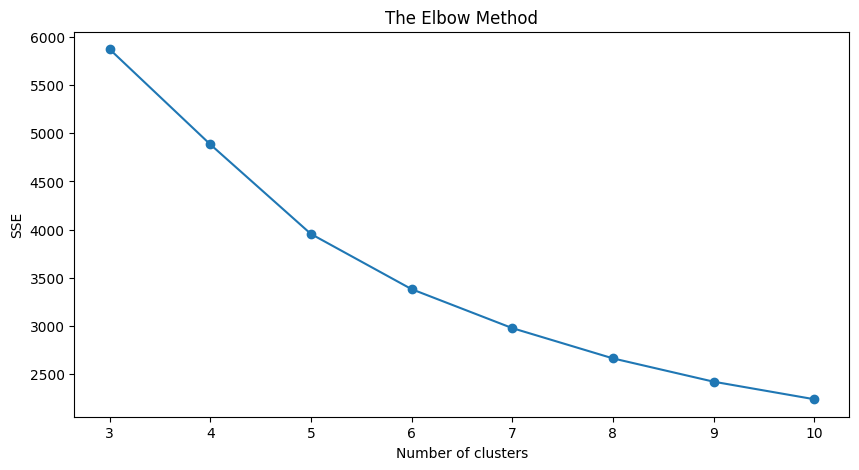

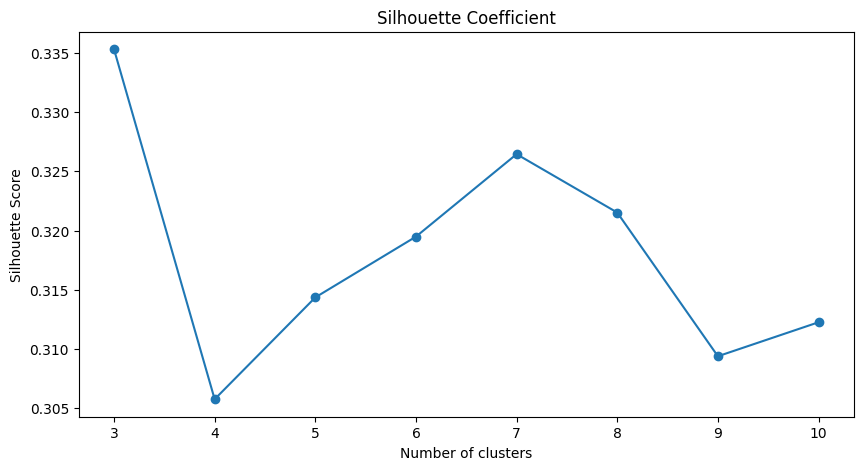

Top 3 highest silhouette scores indices: [0, 4, 5]
Optimal number of clusters by top 3 highest silhouette scores: 3


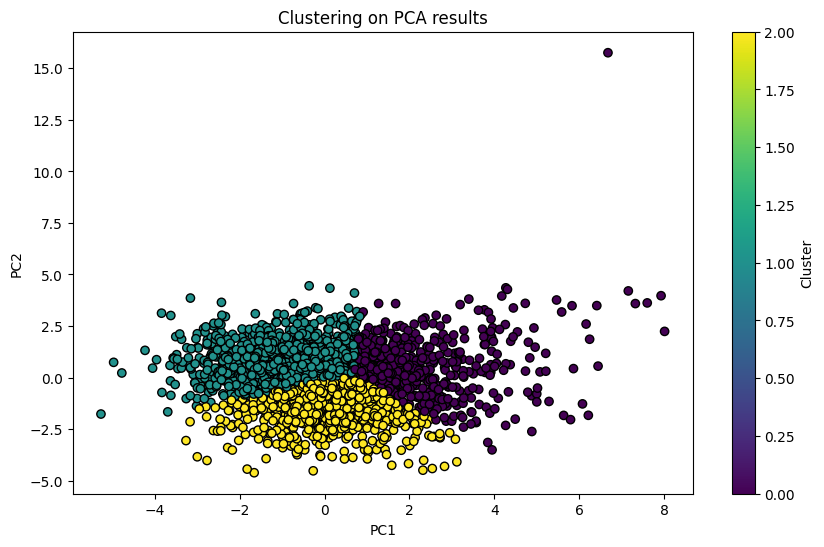

In [16]:
# KMeans
X = df[['PC1', 'PC2']]

# 엘보우 기법을 사용하여 최적의 k 찾기
sse = []
silhouette_coefficients = []
for k in range(3, 11):  # k=2를 제외하고 시작
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

# 엘보우 기법 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(3, 11), sse, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# 실루엣 계수 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(3, 11), silhouette_coefficients, marker='o')
plt.title('Silhouette Coefficient')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# 실루엣 계수가 높은 상위 3개의 k 값을 추출하고 가장 작은 k 선택
top_k_indices = sorted(range(len(silhouette_coefficients)), key=lambda i: silhouette_coefficients[i], reverse=True)[:3]
optimal_k = min([index + 3 for index in top_k_indices])  # 인덱스 조정으로 인해 +3

print(f"Top 3 highest silhouette scores indices: {top_k_indices}")
print(f"Optimal number of clusters by top 3 highest silhouette scores: {optimal_k}")

# 최적의 k로 K-means 클러스터링 수행
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(df['PC1'], df['PC2'], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='black')
plt.title('Clustering on PCA results')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

In [17]:
# TF-IDF
# 각 클러스터별로 TF-IDF 벡터라이저 적용
def cluster_top_tfidf_features(cluster_data, n_terms):
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # 최대 1000개의 단어를 고려
    tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_data)
    feature_array = np.array(tfidf_vectorizer.get_feature_names_out())
    tfidf_sorting = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]
    top_n = feature_array[tfidf_sorting][:n_terms]
    return top_n
# 각 클러스터별 상위 TF-IDF 단어 출력
print("Top terms per cluster:")
for i in range(optimal_k):
    cluster_data = df[df['Cluster'] == i]['tok_text']
    top_terms = cluster_top_tfidf_features(cluster_data, 20)
    print(f"Cluster {i}: {', '.join(top_terms)}")

Top terms per cluster:
Cluster 0: 편의점, 신한카드, 발급, 신청, 서울, 운영, 고객, 없는, 진짜, 하는, 카드, 받을, 받을수, 발표, 발생, 발송, 받으면, 밝은, 밥심, 방금
Cluster 1: 매출, 손님, 해달라고, 결제, 카드, 오늘, 했는데요, 아님, 는데, 신한, 하네요, 입니다, 만원, 많고, 많이, 많아, 많아서, 많은, 마지막, 말씀
Cluster 2: 카드, 대출, 담보, 안된다고, 없나요, 금융, 않을까요, 상환, 다음, 받았어요, 받았는데, 프로, 해보세요, 상품, 어제, 거래, 신한카드, 추가, 금리, 천만원


In [21]:
# gpt-2를 사용해 각 클러스터별 중요 TF-IDF단어 선정
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")
# 주제 입력받기
user_topic = input("Enter a topic you are interested in: ")
def filter_important_words(texts, model, tokenizer, user_topic):
    # 각 텍스트에 대한 중요 단어 평가
    important_words = []
    for text in texts:
        input_ids = tokenizer.encode(user_topic + " " + text, return_tensors='pt')
        outputs = model.generate(input_ids, max_length=50)
        result = tokenizer.decode(outputs[0], skip_special_tokens=True)
        important_words.extend(result.split())  # 결과에서 단어를 리스트에 추가
    return important_words

# 필터링 함수 사용 예시
for i in range(optimal_k):
    cluster_data = df[df['Cluster'] == i]['tok_text']
    top_terms = cluster_top_tfidf_features(cluster_data, 20)
    important_terms = filter_important_words(top_terms, model, tokenizer, user_topic)
    print(f"Cluster {i} important words: {', '.join(set(important_terms))}")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


Cluster 0 important words: 15%, 8조, 있다"며, 매출이, "금융당국이, 지난달까지, 12월31일까지, 전년, 4분기, 계획이다., 2시부터, 관한, 영업이익은, 그런데, 금융주들이, CU(씨유), 금융소비, 매주, 함께, 경제전망’을, 개선세가, 아니다., 밝은, 우리금융은, ‘2019년, 한국경제TV는, 홈페이지(www.hankyung.co, 차지했다., 기록, ‘금융감독원, 통해, 발급을, 전반에, 발송,, 실적도, 말씀드렸듯이, 경우, 국내, 때문에, 진짜, 은행관련, 심사한, CU는, 1000명을, 차익실, 자세한, 발생시, 51.4%가, 잘했어요?", 세미나는, 제공받을, 상승에, 금융회사, 분석에, 양호할, 운영, 금융감독업무, 편의점, 응답자의, 없는, 조언했다., 받을수, 것으로, 설명회는, 신한카드, 맡게, 금융회사들이, 상황에서, 투자전략은, 보호를, 것이다., 대부분, 고객들에게, 있는, 12월말, 홈페이지, 실시됐다., 카드사들의, 밝혔다., 금융상품에, 전국, 절반, 2.06%, 총자산은, 나타났다고, 악화될, 금감원은, 수익성, 우려해, 목요일, 밥심이다., 하는, 실적, 전날보다, 금융감독당국의, 조사에서, 8조원, 업무협약을, 수, 경제전망’, 감독권한이, 이는, "최근, 점검을, 조사는, 금융회사들에, 등을, 오전, 금융소비자보호센터’, 이번, 말했다., 감독을, 1위를, 각종, ', 전화하면, ‘고객만족도’를, 9시30분, 안내할, 2086.49를, 이후, 예상된다"고, 지난해, 받지, 그거야?", 욕구가, 등, 6억원,, 보이고, 위해, 들어, 2046.45를, 기관이, 대비, 받을, 않고, 4시까지, 업무협약은, 커진, 받으면, 강화할, 커질, 하반기, 금융소비자, 업계가, 이날, 오른, 많으시죠., 카드사, 분들이, 설명을, 고객만족도, 홈페이지(www.fss.or.kr)에서, 업무도, 정보공유와, 감독권을, 금융, 늘어난, "올해, 2.09포인트(0.13%), 지금, 금융서비스에, 투자자, 뚜렷

In [23]:
# 중요 단어를 포함한 문장 원문 반출
# 벡터화를 위한 준비
df['text'] = df['text'].fillna('empty')
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['text']).toarray()
# FAISS 인덱스 생성
dimension = X_tfidf.shape[1]  # 특성의 수
index = faiss.IndexFlatL2(dimension)  # L2 거리를 사용하는 평면 인덱스
index.add(X_tfidf.astype(np.float32))  # FAISS는 float32를 사용
def search_documents(query, index, df, top_k=5):
    query_vec = vectorizer.transform([query]).toarray()
    distances, indices = index.search(query_vec.astype(np.float32), top_k)
    return df.iloc[indices[0]]
# 중요 단어 포함 문장 검색
for i in range(optimal_k):
    cluster_data = df[df['Cluster'] == i]['tok_text']
    top_terms = cluster_top_tfidf_features(cluster_data, 20)
    important_terms = filter_important_words(top_terms, model, tokenizer, user_topic)
    for term in important_terms:
        print(f"Search results for {term} in Cluster {i}:")
        results = search_documents(term, index, df)
        print(results['text'])

Search results for 은행관련 in Cluster 0:
99                                                 empty
162    거래처 미수금.떼인돈.채권회수 할수있는 신용정보사를 소개합니다 고려신용정보 이호영팀...
928                  하나은행대출이거맞나요 요상품맞나요 넹 상담하기눌러서 하시면되용.
92     햇살론 받으려다가 새출발기금 문의하러 신복위 내일 상담가요 저자신에게 하는말로 대체...
195    소상공인 대환대출 저금리로 여러은행 동시 신청이 가능한가요 후기첨부 제목 그대로 입...
Name: text, dtype: object
Search results for 분석 in Cluster 0:
99                                                 empty
162    거래처 미수금.떼인돈.채권회수 할수있는 신용정보사를 소개합니다 고려신용정보 이호영팀...
928                  하나은행대출이거맞나요 요상품맞나요 넹 상담하기눌러서 하시면되용.
92     햇살론 받으려다가 새출발기금 문의하러 신복위 내일 상담가요 저자신에게 하는말로 대체...
195    소상공인 대환대출 저금리로 여러은행 동시 신청이 가능한가요 후기첨부 제목 그대로 입...
Name: text, dtype: object
Search results for 편의점 in Cluster 0:
99                                                 empty
162    거래처 미수금.떼인돈.채권회수 할수있는 신용정보사를 소개합니다 고려신용정보 이호영팀...
928                  하나은행대출이거맞나요 요상품맞나요 넹 상담하기눌러서 하시면되용.
92     햇살론 받으려다가 새출발기금 문의하러 신복위 내일 상담가요 저자신에게 하는말로 대체...
195    소상공인 대환대출 저금리로 여러은행 동시 신청이 가능한가요